# CarND-Vehicle-Detection
### Udacity Nanodegree Self-Driving Car Term 1 Project 5

### Import Statements

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Histogram of Oriented Gradients (HOG)

### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

8792 8968


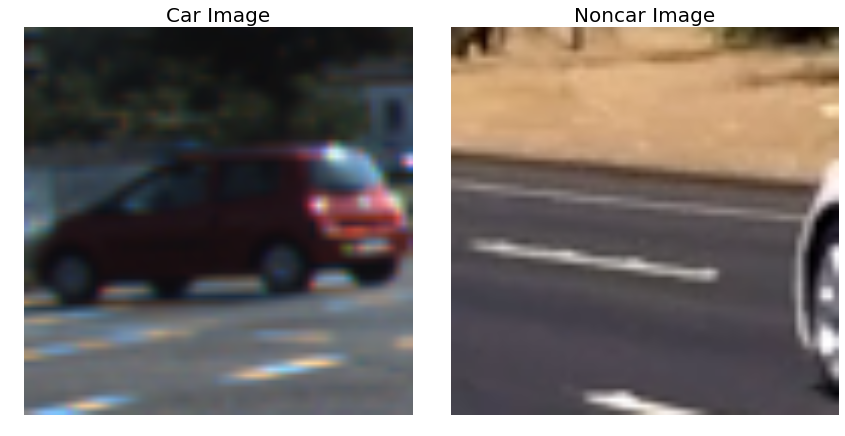

In [2]:
car_images = glob.glob('./training_dataset/vehicles/**/*.png')
noncar_images = glob.glob('./training_dataset/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

car_idx = np.random.randint(len(car_images))
noncar_idx = np.random.randint(len(noncar_images))
car_img = mpimg.imread(car_images[car_idx])
noncar_img = mpimg.imread(noncar_images[noncar_idx])

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
fig.tight_layout()
ax1.imshow(car_img)
ax1.axis('off')
ax1.set_title('Car Image', fontsize=20)
ax2.imshow(noncar_img)
ax2.axis('off')
ax2.set_title('Noncar Image', fontsize=20)

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

#### Visualize HOG on example image

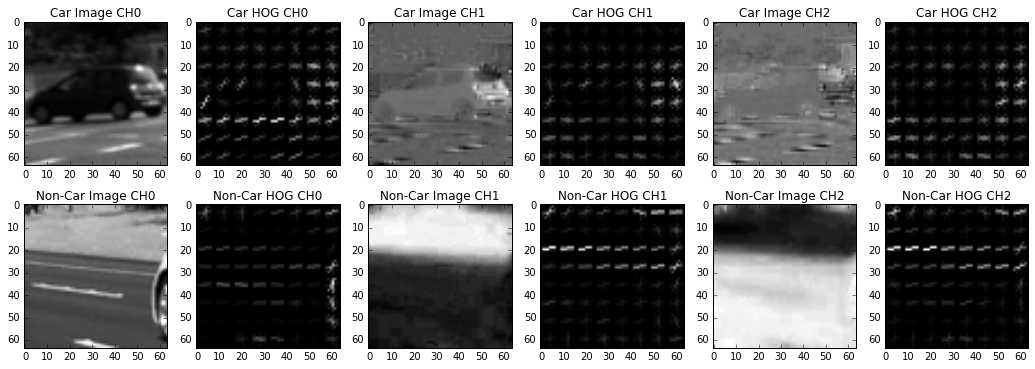

In [4]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

car_img_cspace = cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb)
noncar_img_cspace = cv2.cvtColor(noncar_img, cv2.COLOR_RGB2YCrCb)
car_features_ch0, car_dst_ch0 = get_hog_features(car_img_cspace[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
car_features_ch1, car_dst_ch1 = get_hog_features(car_img_cspace[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
car_features_ch3, car_dst_ch3 = get_hog_features(car_img_cspace[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
noncar_features_ch0, noncar_dst_ch0 = get_hog_features(noncar_img_cspace[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
noncar_features_ch1, noncar_dst_ch1 = get_hog_features(noncar_img_cspace[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
noncar_features_ch3, noncar_dst_ch3 = get_hog_features(noncar_img_cspace[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Visualize 
f, axes = plt.subplots(2, 6, figsize=(18,6))
axes = axes.ravel()
axes[0].imshow(car_img_cspace[:,:,0], cmap='gray')
axes[0].set_title('Car Image CH0', fontsize=12)
axes[1].imshow(car_dst_ch0, cmap='gray')
axes[1].set_title('Car HOG CH0', fontsize=12)
axes[2].imshow(car_img_cspace[:,:,1], cmap='gray')
axes[2].set_title('Car Image CH1', fontsize=12)
axes[3].imshow(car_dst_ch1, cmap='gray')
axes[3].set_title('Car HOG CH1', fontsize=12)
axes[4].imshow(car_img_cspace[:,:,2], cmap='gray')
axes[4].set_title('Car Image CH2', fontsize=12)
axes[5].imshow(car_dst_ch3, cmap='gray')
axes[5].set_title('Car HOG CH2', fontsize=12)

axes[6].imshow(noncar_img_cspace[:,:,0], cmap='gray')
axes[6].set_title('Non-Car Image CH0', fontsize=12)
axes[7].imshow(noncar_dst_ch0, cmap='gray')
axes[7].set_title('Non-Car HOG CH0', fontsize=12)
axes[8].imshow(noncar_img_cspace[:,:,1], cmap='gray')
axes[8].set_title('Non-Car Image CH1', fontsize=12)
axes[9].imshow(noncar_dst_ch1, cmap='gray')
axes[9].set_title('Non-Car HOG CH1', fontsize=12)
axes[10].imshow(noncar_img_cspace[:,:,2], cmap='gray')
axes[10].set_title('Non-Car Image CH2', fontsize=12)
axes[11].imshow(noncar_dst_ch3, cmap='gray')
axes[11].set_title('Non-Car HOG CH2', fontsize=12)

### 2. Explain how you settled on your final choice of HOG parameters.

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, bins_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=bins_range)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

#### Extraction of the HOG Features

In [6]:
#color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
#color_space = 'YCrCb'
color_space = 'YUV'
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL'
#hog_channel = ['ALL', '0', '1', '2'] 
spatial_size = (64, 64)
hist_bins = 32
bins_range = (0, 1)
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off


print('Color Space: ' + color_space)
t = time.time()
car_features = extract_features(car_images, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins, bins_range=bins_range,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(noncar_images, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins, bins_range=bins_range,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

Color Space: YUV
64.19 Seconds to extract HOG features...


#### Trainning the SVM Linear Classifier

In [7]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)  
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#Normalize
#X_scaler = StandardScaler().fit(X)
#scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
#X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188
1.5 Seconds to train SVC...
Test Accuracy of SVC =  0.9831


## Sliding Window Search

### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

In [120]:
def find_cars(img, ystart, ystop, xstart, xstop, color_space, scale, svc, orient, pix_per_cell, cell_per_block, show_all_rects=False):
    
    #draw_img = np.copy(img)
    rects = []
    img = img.astype(np.float32)/255
    
    if ystart == None:
        ystart = 0
    if ystop == None:
        ystop = img.shape[0]
    if xstart == None:
        xstart = 0
    if xstop == None:
        xstop = img.shape[1]
    
    img_tosearch = img[ystart:ystop, xstart:xstop,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)  
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1 
    #nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    #nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    #nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rects:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rects.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return rects
    #return draw_img

In [121]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=3):
    draw_img = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    return draw_img

#### Draw all the search rectangles onto an example image

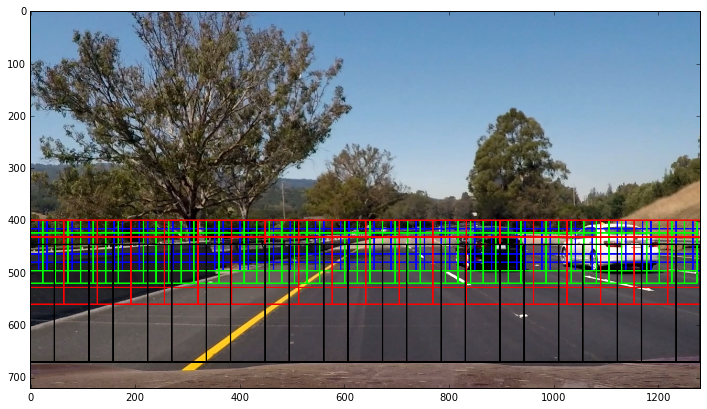

In [132]:
test_img = mpimg.imread('./test_images/test6.jpg')
#rects = []

ystart = 400
ystop = 496
scale = 1
rects_1 = find_cars(test_img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block, show_all_rects=True) 
draw_img = draw_boxes(test_img, rects_1, thick=2)

ystart = 400
ystop = 496
xstart = 16
scale = 1
rects_1 = find_cars(test_img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block, show_all_rects=True) 
draw_img = draw_boxes(draw_img, rects_1, thick=2)

ystart = 416
ystop = 480
scale = 1
rects_1 = find_cars(test_img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block, show_all_rects=True) 
draw_img = draw_boxes(draw_img, rects_1, thick=2)

ystart = 416
ystop = 480
xstart = 16
scale = 1
rects_1 = find_cars(test_img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block, show_all_rects=True) 
draw_img = draw_boxes(draw_img, rects_1, thick=2)

ystart = 400
ystop = 496
scale = 1.5
rects_1_5 = find_cars(test_img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block, show_all_rects=True) 
draw_img = draw_boxes(draw_img, rects_1_5, color=(0, 255, 0), thick=2)

ystart = 400
ystop = 496
xstart = 24
scale = 1.5
rects_1_5 = find_cars(test_img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block, show_all_rects=True) 
draw_img = draw_boxes(draw_img, rects_1_5, color=(0, 255, 0), thick=2)

ystart = 424
ystop = 520
scale = 1.5
rects_1_5 = find_cars(test_img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block, show_all_rects=True) 
draw_img = draw_boxes(draw_img, rects_1_5, color=(0, 255, 0), thick=2)

ystart = 424
ystop = 520
xstart = 24
scale = 1.5
rects_1_5 = find_cars(test_img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block, show_all_rects=True) 
draw_img = draw_boxes(draw_img, rects_1_5, color=(0, 255, 0), thick=2)

ystart = 400
ystop = 528
scale = 2
rects_2 = find_cars(test_img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block, show_all_rects=True) 
draw_img = draw_boxes(draw_img, rects_2, color=(255, 0, 0), thick=2)

ystart = 432
ystop = 560
scale = 2
rects_2 = find_cars(test_img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block, show_all_rects=True) 
draw_img = draw_boxes(draw_img, rects_2, color=(255, 0, 0), thick=2)

ystart = 446
ystop = 670
scale = 3.5
rects_3_5 = find_cars(test_img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block, show_all_rects=True) 
draw_img = draw_boxes(draw_img, rects_3_5, color=(0, 0, 0), thick=2)

ystart = 446
ystop = 670
xstart = 46
scale = 3.5
rects_3_5 = find_cars(test_img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block, show_all_rects=True) 
draw_img = draw_boxes(draw_img, rects_3_5, color=(0, 0, 0), thick=2)

plt.figure(figsize=(12, 8))
plt.imshow(draw_img)

### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

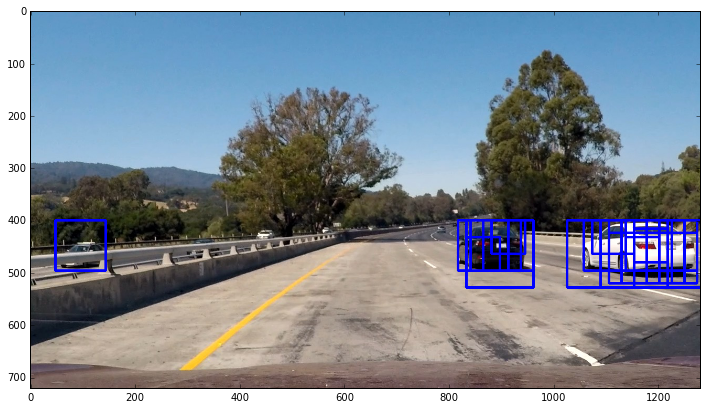

In [157]:
test_img = mpimg.imread('./test_images/test1.jpg')
rects = []
draw_img = np.copy(test_img)

ystart = 400
ystop = 496
scale = 1
rects.extend(find_cars(test_img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

ystart = 400
ystop = 496
xstart = 16
scale = 1
rects.extend(find_cars(test_img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

ystart = 416
ystop = 480
scale = 1
rects.extend(find_cars(test_img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

ystart = 416
ystop = 480
xstart = 16
scale = 1
rects.extend(find_cars(test_img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

ystart = 400
ystop = 496
scale = 1.5
rects.extend(find_cars(test_img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

ystart = 400
ystop = 496
xstart = 24
scale = 1.5
rects.extend(find_cars(test_img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

ystart = 424
ystop = 520
scale = 1.5
rects.extend(find_cars(test_img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

ystart = 424
ystop = 520
xstart = 24
scale = 1.5
rects.extend(find_cars(test_img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

ystart = 400
ystop = 528
scale = 2
rects.extend(find_cars(test_img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

ystart = 432
ystop = 560
scale = 2
rects.extend(find_cars(test_img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

ystart = 446
ystop = 670
scale = 3.5
rects.extend(find_cars(test_img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

ystart = 446
ystop = 670
xstart = 46
scale = 3.5
rects.extend(find_cars(test_img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))
'''
ystart = 400
ystop = 496
scale = 1
rects.extend(find_cars(test_img, ystart, ystop, color_space, scale, svc, orient, pix_per_cell, cell_per_block)) 

ystart = 416
ystop = 480
scale = 1
rects.extend(find_cars(test_img, ystart, ystop, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

ystart = 400
ystop = 496
scale = 1.5
rects.extend(find_cars(test_img, ystart, ystop, color_space, scale, svc, orient, pix_per_cell, cell_per_block)) 

ystart = 432
ystop = 528
scale = 1.5
rects.extend(find_cars(test_img, ystart, ystop, color_space, scale, svc, orient, pix_per_cell, cell_per_block)) 

ystart = 400
ystop = 528
scale = 2
rects.extend(find_cars(test_img, ystart, ystop, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

ystart = 432
ystop = 560
scale = 2
rects.extend(find_cars(test_img, ystart, ystop, color_space, scale, svc, orient, pix_per_cell, cell_per_block)) 

ystart = 446
ystop = 670
scale = 3.5
rects.extend(find_cars(test_img, ystart, ystop, color_space, scale, svc, orient, pix_per_cell, cell_per_block))
'''
draw_img = draw_boxes(draw_img, rects)

plt.figure(figsize=(12, 8))
plt.imshow(draw_img)

#### Heatmap

In [158]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

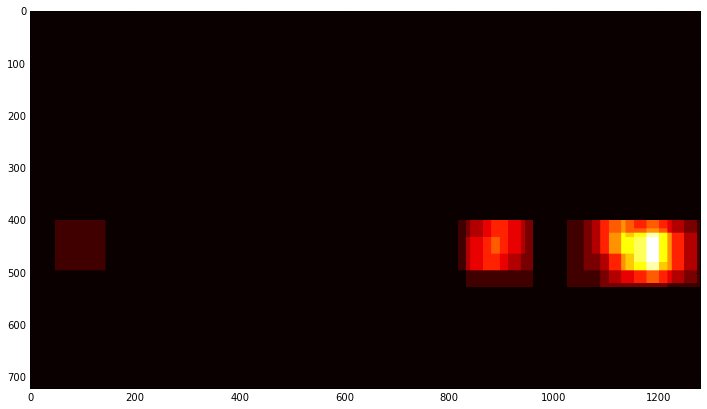

In [159]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rects)
plt.figure(figsize=(12, 8))
plt.imshow(heatmap_img, cmap='hot')

In [160]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

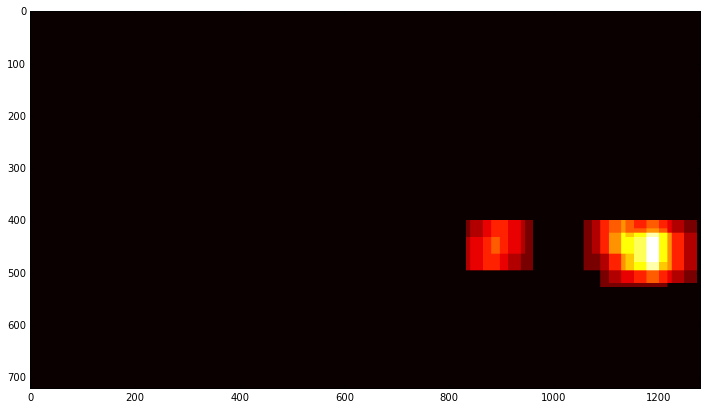

In [161]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(12, 8))
plt.imshow(heatmap_img, cmap='hot')

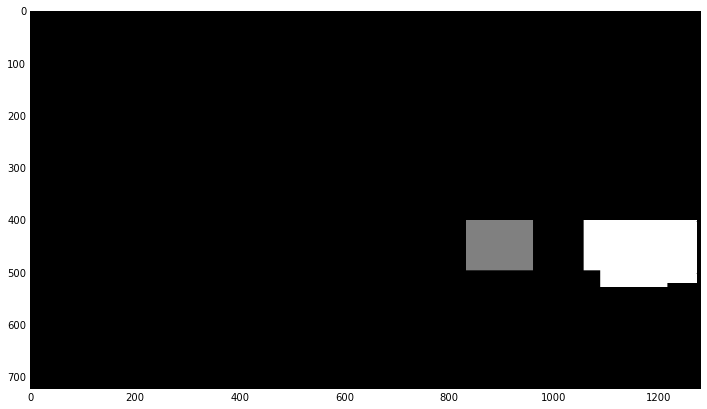

In [162]:
labels = label(heatmap_img)
plt.figure(figsize=(12, 8))
plt.imshow(labels[0], cmap='gray')

In [163]:
def draw_labeled_bboxes(img, labels):
    rects = []
    out_img = np.copy(img)
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        cv2.rectangle(out_img, bbox[0], bbox[1], (0, 0, 255), 3)
    return out_img, rects

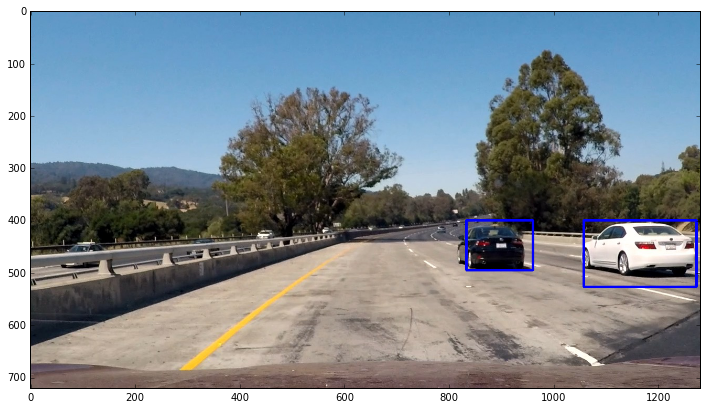

In [164]:
draw_img, rects = draw_labeled_bboxes(test_img, labels)
plt.figure(figsize=(12, 8))
plt.imshow(draw_img)

#### Pipeline

In [153]:
def Pipeline(img):
    rects = []
    
    color_space = 'YUV'
    orient = 11  # HOG orientations
    pix_per_cell = 16 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL'
    
    ystart = 400
    ystop = 496
    scale = 1
    rects.extend(find_cars(img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 400
    ystop = 496
    xstart = 16
    scale = 1
    rects.extend(find_cars(img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 416
    ystop = 480
    scale = 1
    rects.extend(find_cars(img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 416
    ystop = 480
    xstart = 16
    scale = 1
    rects.extend(find_cars(img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 400
    ystop = 496
    scale = 1.5
    rects.extend(find_cars(img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 400
    ystop = 496
    xstart = 24
    scale = 1.5
    rects.extend(find_cars(img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 424
    ystop = 520
    scale = 1.5
    rects.extend(find_cars(img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 424
    ystop = 520
    xstart = 24
    scale = 1.5
    rects.extend(find_cars(img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 400
    ystop = 528
    scale = 2
    rects.extend(find_cars(img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 432
    ystop = 560
    scale = 2
    rects.extend(find_cars(img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 446
    ystop = 670
    scale = 3.5
    rects.extend(find_cars(img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 446
    ystop = 670
    xstart = 46
    scale = 3.5
    rects.extend(find_cars(img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rects)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(img, labels)
    
    return draw_img


#### Test Images

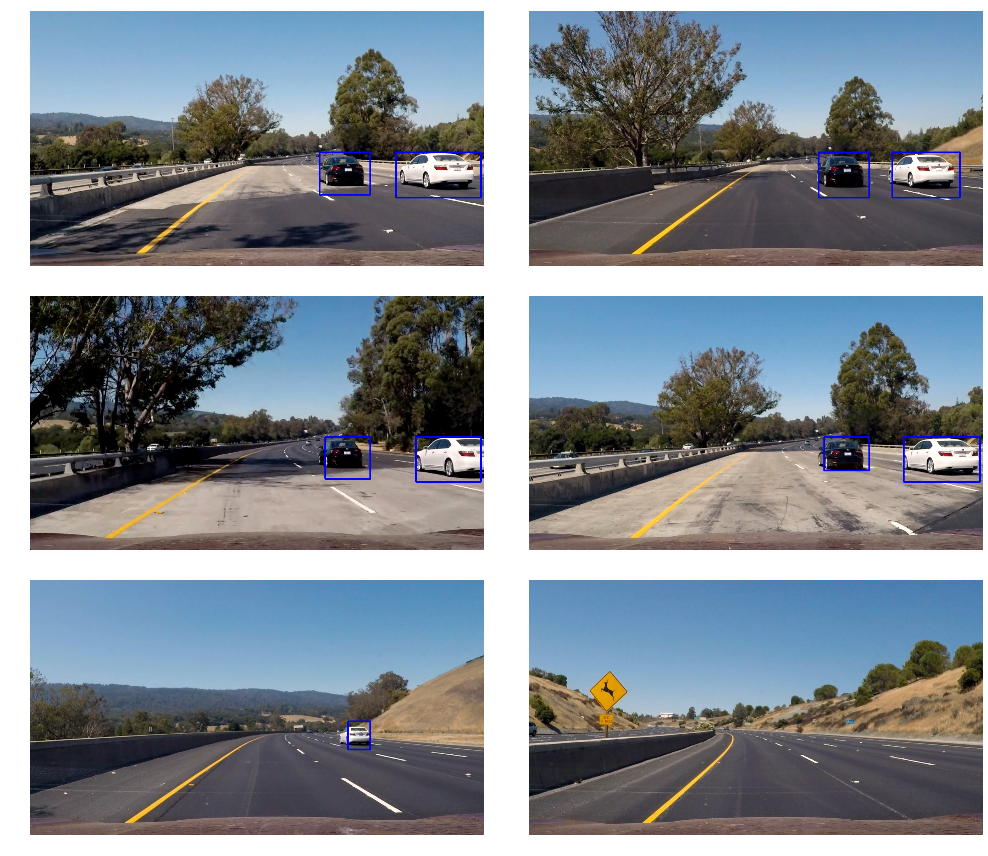

In [154]:
test_imgs = glob.glob('./test_images/test*.jpg')

fig, axes = plt.subplots(int(len(test_imgs)/2), 2, figsize=(14, 12))
fig.tight_layout()
axes = axes.ravel()

for i, img in enumerate(test_imgs):
    axes[i].imshow(Pipeline(mpimg.imread(img)))
    axes[i].axis('off')

## Video Implementation

### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

In [155]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(Pipeline)
clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:37<00:00,  1.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 



### 2. Advanced Pipeline with a Class to Store Data

In [172]:
class Rects_Store():
    def __init__(self, store_max):
        self.rects = []
        self.counter = 0
        self.false_counter = 0
        self.store_max = int(store_max)
        
    def add_rects(self, rects):
        self.rects.append(rects)
        if len(self.rects) > self.store_max:
            self.rects = self.rects[len(self.rects)-self.store_max:]


In [179]:
def Pipeline_advanced(img):
    rects = []
    
    color_space = 'YUV'
    orient = 11  # HOG orientations
    pix_per_cell = 16 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL'
    
    ystart = 400
    ystop = 496
    scale = 1
    rects.extend(find_cars(img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 400
    ystop = 496
    xstart = 16
    scale = 1
    rects.extend(find_cars(img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 416
    ystop = 480
    scale = 1
    rects.extend(find_cars(img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 416
    ystop = 480
    xstart = 16
    scale = 1
    rects.extend(find_cars(img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 400
    ystop = 496
    scale = 1.5
    rects.extend(find_cars(img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 400
    ystop = 496
    xstart = 24
    scale = 1.5
    rects.extend(find_cars(img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 424
    ystop = 520
    scale = 1.5
    rects.extend(find_cars(img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 424
    ystop = 520
    xstart = 24
    scale = 1.5
    rects.extend(find_cars(img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 400
    ystop = 528
    scale = 2
    rects.extend(find_cars(img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 432
    ystop = 560
    scale = 2
    rects.extend(find_cars(img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 446
    ystop = 670
    scale = 3.5
    rects.extend(find_cars(img, ystart, ystop, None, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))

    ystart = 446
    ystop = 670
    xstart = 46
    scale = 3.5
    rects.extend(find_cars(img, ystart, ystop, xstart, None, color_space, scale, svc, orient, pix_per_cell, cell_per_block))
    
    if len(rects) > 0:
        store_rects.add_rects(rects)
    else:
        if store_rects.counter - store_rects.false_counter > 2:
            store_rects.rects = []    
        store_rects.false_counter = store_rects.counter
         
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_list in store_rects.rects:
        heatmap_img = add_heat(heatmap_img, rect_list)
    
    heatmap_img = apply_threshold(heatmap_img, 1+len(store_rects.rects)//2)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(img, labels)
    
    store_rects.counter += 1
    
    return draw_img


#### Test Video Anvanced

In [180]:
store_rects = Rects_Store(10)

test_out_file_advanced = 'test_video_out_advanced.mp4'
clip_test_advanced = VideoFileClip('test_video.mp4')
clip_test_out_advanced = clip_test_advanced.fl_image(Pipeline_advanced)
clip_test_out_advanced.write_videofile(test_out_file_advanced, audio=False)

[MoviePy] >>>> Building video test_video_out_advanced.mp4
[MoviePy] Writing video test_video_out_advanced.mp4



 97%|█████████▋| 38/39 [00:39<00:01,  1.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_advanced.mp4 



#### Project Video

In [181]:
store_rects = Rects_Store(20)

proj_out_file_advanced = 'project_video_out_advanced.mp4'
clip_proj_advanced = VideoFileClip('project_video.mp4')
clip_proj_out_advanced = clip_proj_advanced.fl_image(Pipeline_advanced)
clip_proj_out_advanced.write_videofile(proj_out_file_advanced, audio=False)

[MoviePy] >>>> Building video project_video_out_advanced.mp4
[MoviePy] Writing video project_video_out_advanced.mp4



100%|█████████▉| 1260/1261 [25:32<00:01,  1.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_advanced.mp4 

